In [137]:

import sys
import numpy as np
from mynn import *
from mydata import *
from datetime import datetime

import matplotlib as mpl 
from matplotlib.lines import Line2D 
# mpl.use('TkAgg')
import matplotlib.pyplot as plt
from laplace import Laplace


# plt.rc("figure", dpi=300)           # High-quality figure ("dots-per-inch")
# plt.rc("text", usetex=True)         # Crisp axis ticks
# plt.rc("font", family="serif")      # Crisp axis labels
# plt.rc("legend", edgecolor='none')  # No boxes around legends

# plt.rc("figure",facecolor="#ffffff")
# plt.rc("axes",facecolor="#ffffff",edgecolor="#000000",labelcolor="#000000")
# plt.rc("savefig",facecolor="#ffffff")
# plt.rc("text",color="#000000")
# plt.rc("xtick",color="#000000")
# plt.rc("ytick",color="#000000")

color1 = 'tab:blue'
color2 = 'tab:green'
color3 = 'tab:orange'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
test_error_mean = {"16":dict(),"64":dict(),"128":dict()}


In [138]:
#[16,64, 128]
#[312, 624, 1250,2500]
for nneurons in [16,64, 128]:
    test_error_mean[str(nneurons)]["ParaNet"] = []
    for M in [624]:
        
        N = 100
        ntrain = M//2

        inputs = np.load("../../../../data//Helmholtz_inputs.npy")   
        outputs = np.load("../../../../data/Helmholtz_outputs.npy")  

        K_test = outputs[:, :, M//2:M]
        acc = 0.99

        xgrid = np.linspace(0,1,N+1)
        dx    = xgrid[1] - xgrid[0]

        train_inputs = np.reshape(inputs[:,:,:M//2], (-1, M//2))
        test_inputs  = np.reshape(inputs[:,:,M//2:M], (-1, M-M//2))
        Ui,Si,Vi = np.linalg.svd(train_inputs)
        en_f= 1 - np.cumsum(Si)/np.sum(Si)
        r_f = np.argwhere(en_f<(1-acc))[0,0]

        r_f = 101#r_f = min(r_f, 512)
        

        Uf = Ui[:,:r_f]
        f_hat = np.matmul(Uf.T,train_inputs)
        f_hat_test = np.matmul(Uf.T,test_inputs)
        x_train_part = f_hat.T.astype(np.float32)
        x_test_part = f_hat_test.T.astype(np.float32)

        del inputs
        del Ui, Vi, Uf,f_hat

        ########### Test
        Y, X = np.meshgrid(xgrid, xgrid)
        # test
        i = 20
        j = 40
        assert(X[i, j] == i*dx and Y[i, j] == j*dx)

        X_upper = np.reshape(X, -1)
        Y_upper = np.reshape(Y, -1)
        N_upper = len(X_upper)
        x_train = np.zeros((M//2 * N_upper, r_f + 2), dtype = np.float32)
        y_train = np.zeros(M//2 * N_upper, dtype = np.float32)

        for i in range(M//2):
            d_range = range(i*N_upper, (i + 1)*N_upper)
            x_train[d_range , 0:r_f]   = x_train_part[i, :]
            x_train[d_range , r_f]     = X_upper
            x_train[d_range , r_f + 1] = Y_upper 
            y_train[d_range] = np.reshape(outputs[:, :, i], -1)


        x_train = torch.from_numpy(x_train)
        y_train = torch.from_numpy(y_train).unsqueeze(-1)

        x_normalizer = UnitGaussianNormalizer(x_train)
        x_normalizer.encode_(x_train)


        x_test = np.zeros(((M-M//2) * N_upper, r_f + 2), dtype = np.float32)
        for i in range(M-M//2):
            d_range = range(i*N_upper, (i + 1)*N_upper)
            x_test[d_range , 0:r_f]   = x_test_part[i, :]
            x_test[d_range , r_f]     = X_upper
            x_test[d_range , r_f + 1] = Y_upper 

        # x_normalizer.cpu()
        x_test = torch.from_numpy(x_test)
        x_normalizer.encode_(x_test)
        y_normalizer = UnitGaussianNormalizer(y_train)
        batch_size = 8192

        train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)



        model = torch.load("../../../../data/Models/ParaNet/ParaNet_101_"+str(nneurons)+"Nd_"+str(ntrain)+".model", map_location=device)
        model.to(device)

        rel_err_nn_test = np.zeros(M//2)
        for i in range(M-M//2):
            print("i / N = ", i, " / ", M-M//2)
            K_test_pred_upper = y_normalizer.decode(model(x_test[i*N_upper:(i+1)*N_upper, :].to(device)).detach()).cpu().numpy()
            K_test_pred = np.reshape(K_test_pred_upper, (N+1,N+1))
            rel_err_nn_test[i] =  np.linalg.norm(K_test_pred - K_test[:, :, i])/np.linalg.norm(K_test[:, :, i])
        mre_nn_test = np.mean(rel_err_nn_test)

        test_error_mean[str(nneurons)]["ParaNet"].append(mre_nn_test)


        # User-specified LA flavor
        la = Laplace(model, "regression",subset_of_weights="last_layer",hessian_structure="full")
        la.fit(train_loader)

        log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
        hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)

        for i in range(5000):
            hyper_optimizer.zero_grad()
            neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
            neg_marglik.backward()
            hyper_optimizer.step()
            
        i = np.argmax(rel_err_nn_test)
        mean, var = la(x_test[i*N_upper:(i+1)*N_upper, :].to(device))
        K_test_pred_upper = y_normalizer.decode(mean).detach().cpu().numpy()
        K_test_pred_var = np.reshape(var.detach().cpu().numpy(), (N+1,N+1))

        np.save(str(ntrain) + "_" + str(nneurons)+"Nd_"+str(ntrain) + "_test_output_save.npy", K_test_pred_upper)
        np.save(str(ntrain) + "_" + str(nneurons)+"Nd_"+str(ntrain) + "_test_var_output_save.npy", K_test_pred_var)
        np.save(str(ntrain) + "_" + str(nneurons)+"Nd_"+str(ntrain) + "_test_thruth_save.npy", K_test[:,:,i])

        K_test[:,:,i]
        

i / N =  0  /  312
i / N =  1  /  312
i / N =  2  /  312
i / N =  3  /  312
i / N =  4  /  312
i / N =  5  /  312
i / N =  6  /  312
i / N =  7  /  312
i / N =  8  /  312
i / N =  9  /  312
i / N =  10  /  312
i / N =  11  /  312
i / N =  12  /  312
i / N =  13  /  312
i / N =  14  /  312
i / N =  15  /  312
i / N =  16  /  312
i / N =  17  /  312
i / N =  18  /  312
i / N =  19  /  312
i / N =  20  /  312
i / N =  21  /  312
i / N =  22  /  312
i / N =  23  /  312
i / N =  24  /  312
i / N =  25  /  312
i / N =  26  /  312
i / N =  27  /  312
i / N =  28  /  312
i / N =  29  /  312
i / N =  30  /  312
i / N =  31  /  312
i / N =  32  /  312
i / N =  33  /  312
i / N =  34  /  312
i / N =  35  /  312
i / N =  36  /  312
i / N =  37  /  312
i / N =  38  /  312
i / N =  39  /  312
i / N =  40  /  312
i / N =  41  /  312
i / N =  42  /  312
i / N =  43  /  312
i / N =  44  /  312
i / N =  45  /  312
i / N =  46  /  312
i / N =  47  /  312
i / N =  48  /  312
i / N =  49  /  312
i / N =  5

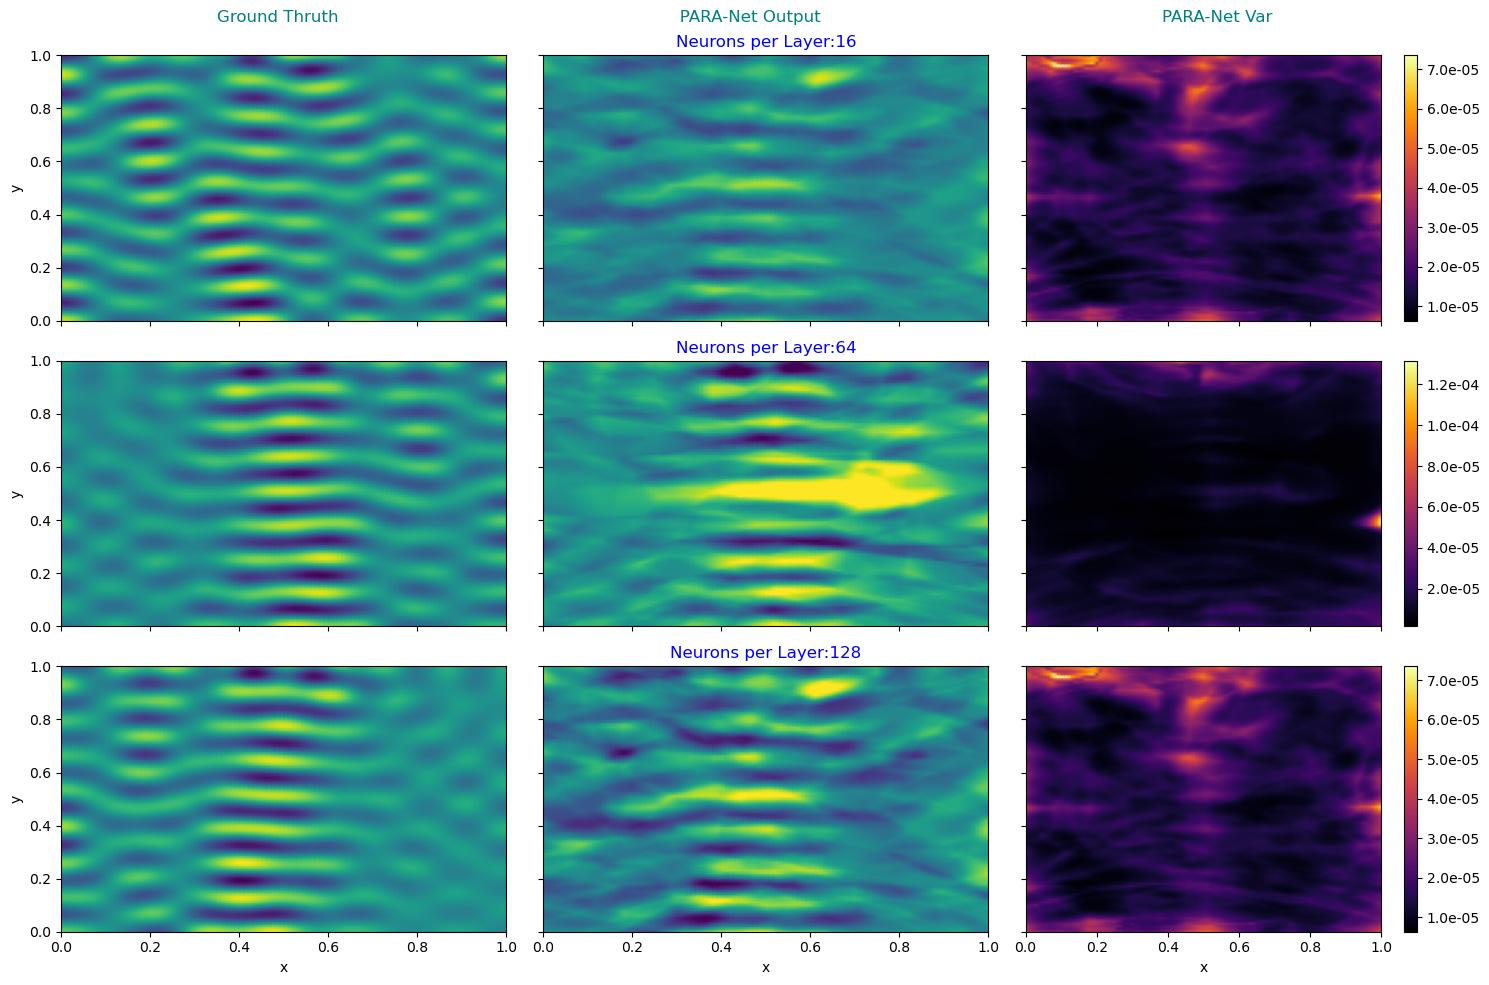

In [175]:
from matplotlib.ticker import FuncFormatter

fig,ax = plt.subplots(3,4, figsize=(15,10),sharex= True, sharey = True)

fmt = lambda x, pos: '{:.1e}'.format(x)

fig.suptitle("Ground Thruth"+65*" "+"PARA-Net Output" +65*" "+"PARA-Net Var",color = "teal")

for i,nneurons in  enumerate([16,64, 128]):
    K_test_pred = np.load(str(ntrain) + "_" + str(nneurons)+"Nd_"+str(ntrain) + "_test_output_save.npy")
    K_test_var = np.load(str(ntrain) + "_" + str(nneurons)+"Nd_"+str(ntrain) + "_test_var_output_save.npy")
    K_test_ = np.load(str(ntrain) + "_" + str(nneurons)+"Nd_"+str(ntrain) + "_test_thruth_save.npy")

    vmin, vmax = K_test_.min(), K_test_.max()
    ax[i,0].pcolormesh(X, Y, K_test_, shading='gouraud', vmin=vmin, vmax =vmax,label = 'Ground Thruth')
    ax[i,1].pcolormesh(X, Y, np.reshape(K_test_pred, (N+1,N+1)), shading='gouraud', vmin=vmin, vmax =vmax, label = 'PARA-Net Output')
    im = ax[i,2].pcolormesh(X, Y, np.reshape(K_test_var, (N+1,N+1)), shading='gouraud',cmap = "inferno", label = 'PARA-Net UQ')

    ax[-1,0].set_xlabel('x'), ax[-1,1].set_xlabel('x'), ax[-1,2].set_xlabel('x')
    ax[0,0].set_ylabel('y'), ax[1,0].set_ylabel('y'), ax[2,0].set_ylabel('y')
    ax[i,1].set_title(f'Neurons per Layer:{nneurons}', color = "b")
    fig.colorbar(im,format = fmt)

    plt.tight_layout()

In [132]:
i = np.argmax(rel_err_nn_test)
mean, var = la(x_test[i*N_upper:(i+1)*N_upper, :].to(device))
std = torch.sqrt(var.reshape_as(mean))
K_test_pred_upper = y_normalizer.decode(mean).detach().cpu().numpy()
K_test_pred_std_pos = y_normalizer.decode(mean+2*std).detach().cpu().numpy()
K_test_pred_std_neg = y_normalizer.decode(mean-2*std).detach().cpu().numpy()

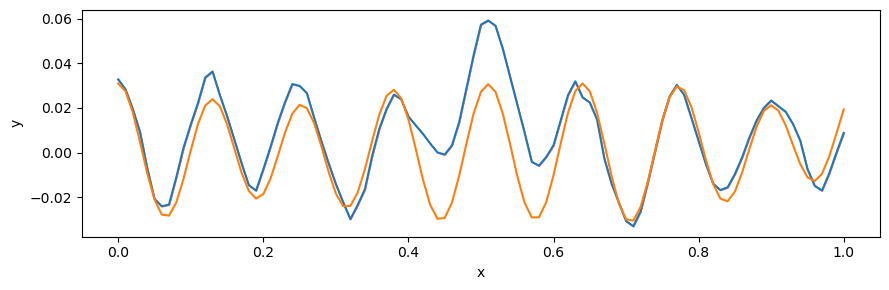

In [135]:
K_test_pred = np.reshape(K_test_pred_upper, (N+1,N+1))
K_test_pred_std_pos = np.reshape(K_test_pred_std_pos, (N+1,N+1))
K_test_pred_std_neg = np.reshape(K_test_pred_std_neg, (N+1,N+1))

fig,ax = plt.subplots(ncols=1, figsize=(9,3))

ax.plot(xgrid, K_test_pred[50,:])
ax.plot(xgrid, K_test[50,:,i])
ax.fill_between(xgrid, K_test_pred_std_pos[50,:],K_test_pred_std_neg[50,:],alpha=0.4, color = "red")

plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()

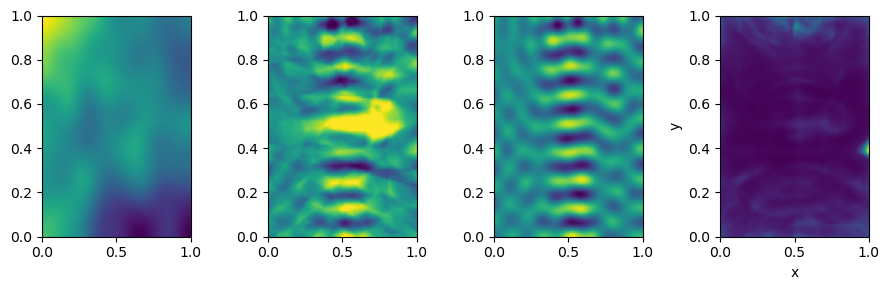

In [136]:
K_test_pred = np.reshape(K_test_pred_upper, (N+1,N+1))

fig,ax = plt.subplots(ncols=4, figsize=(9,3))
vmin, vmax = K_test[:,:,i].min(), K_test[:,:,i].max()
ax[0].pcolormesh(X, Y, np.reshape(test_inputs[:, i], (N+1,N+1)),  shading='gouraud')
ax[1].pcolormesh(X, Y, K_test_pred, shading='gouraud', vmin=vmin, vmax =vmax)
ax[2].pcolormesh(X, Y, K_test[:,:,i], shading='gouraud', vmin=vmin, vmax =vmax)
ax[3].pcolormesh(X, Y, np.reshape(var, (N+1,N+1)), shading='gouraud')

plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()

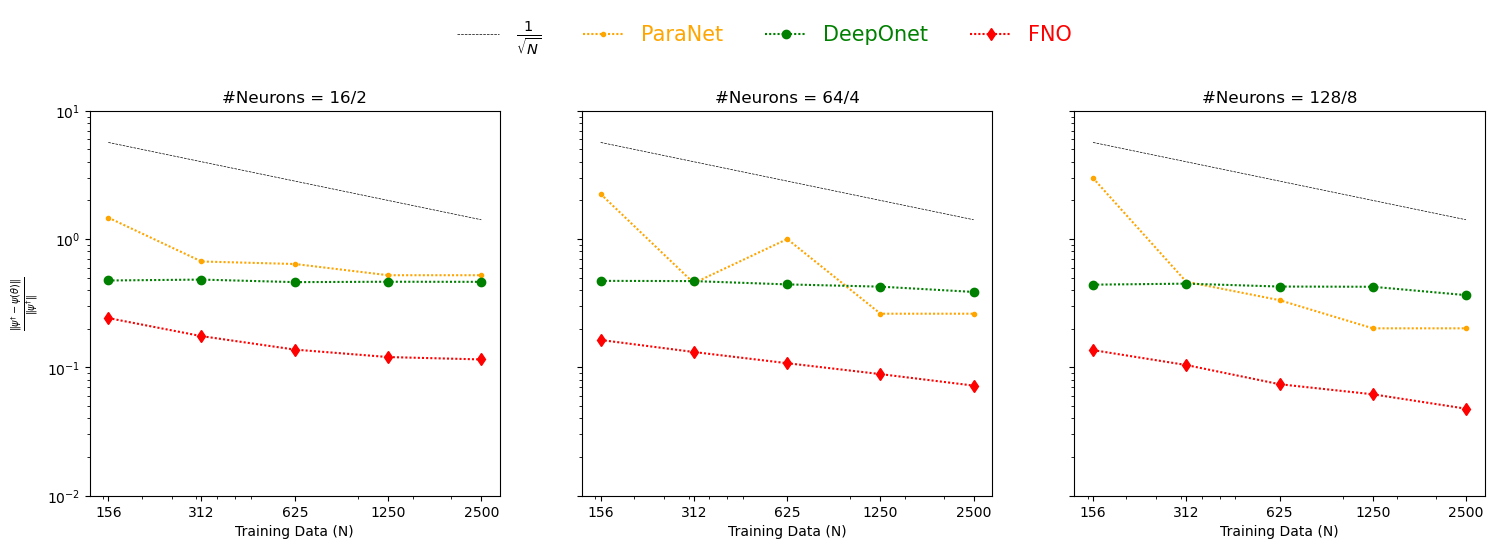

In [50]:
d = np.array([312, 624, 1250, 2500,5000])


#plt.loglog(d, 1/np.sqrt(d),color = "blue", label= r"$\frac{1}{\sqrt{N}}$")
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
ylims = [(1e-2, 10), (1e-2, 10), (0.04, 0.4), (0.1, 10)]
networks = ["#Neurons = 16/2", "#Neurons = 64/4", "#Neurons = 128/8"]
for i,(key,ax) in enumerate(zip(test_error_mean.keys(),axs.flatten())):

    ax.loglog(d,100*d**(-1/2),label = r"$\frac{1}{\sqrt{N}}$",color = "black",linewidth=0.5,linestyle="dashed")
    ax.loglog(d,np.array(test_error_mean[str(key)]["ParaNet"]), marker = ".",color = "orange",linestyle=(0,(1,1)),label = "ParaNet")
    ax.loglog(d,np.array(test_error_mean[str(key)]["DeepOnet"]),marker = "o", color = "green",linestyle=(0,(1,1)),label = "DeepOnet")
    ax.loglog(d,np.array(test_error_mean[str(key)]["FNO"]), marker = "d", color = "red",linestyle=(0,(1,1)),label = "FNO")
    #ax.set_yscale('log')
    ax.set_xlabel(f"Training Data (N)")
    ax.set_title(networks[i])
    ax.set_xticks(d)
    ax.set_xticklabels(["156","312","625","1250","2500"])

axs[0].set_ylim(ylims[0])
axs[0].set_ylabel(r"$\frac {\| \psi^{\dag} - \psi(\theta)\|}{\| \psi^{\dag}\|}$")

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles,labels,loc = "lower center",bbox_to_anchor=(0.5,0.95),ncol=4,frameon=False,fontsize=15,labelcolor="linecolor")

In [ ]:
import sys
import numpy as np
from mynn import *
from mydata import *

from Adam import Adam
import operator
from functools import reduce
from functools import partial
import matplotlib.pyplot as plt
from timeit import default_timer
import numpy as np

torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

M_  = [2500]
for M in M_:
    N = 100

    ntrain = M//2
    acc = 0.99

    xgrid = np.linspace(0,1,N+1)
    dx    = xgrid[1] - xgrid[0]


    inputs = np.load("../../../../data/Helmholtz_inputs.npy")   
    outputs = np.load("../../../../data/Helmholtz_outputs.npy")   

    train_inputs = np.reshape(inputs[:,:,:M//2], (-1, M//2))
    Ui,Si,Vi = np.linalg.svd(train_inputs)
    en_f= 1 - np.cumsum(Si)/np.sum(Si)
    r_f = np.argwhere(en_f<(1-acc))[0,0]
    r_f = 101#r_f = min(r_f, 512)
    print("Energy is ", en_f[r_f - 1])
    Uf = Ui[:,:r_f]
    f_hat = np.matmul(Uf.T,train_inputs)
    x_train_part = f_hat.T.astype(np.float32)

    del train_inputs
    del inputs
    del Ui, Vi, Uf, f_hat

    Y, X = np.meshgrid(xgrid, xgrid)
    # test
    i = 20
    j = 40
    assert(X[i, j] == i*dx and Y[i, j] == j*dx)

    X_upper = np.reshape(X, -1)
    Y_upper = np.reshape(Y, -1)
    N_upper = len(X_upper)
    x_train = np.zeros((M//2 * N_upper, r_f + 2), dtype = np.float32)
    y_train = np.zeros(M//2 * N_upper, dtype = np.float32)



    for i in range(M//2):
        d_range = range(i*N_upper, (i + 1)*N_upper)
        x_train[d_range , 0:r_f]   = x_train_part[i, :]
        x_train[d_range , r_f]     = X_upper
        x_train[d_range , r_f + 1] = Y_upper 
        y_train[d_range] = np.reshape(outputs[:, :, i], -1)


    print("Input dim : ", r_f+2, " output dim : ", 1)


    x_train = torch.from_numpy(x_train)
    y_train = torch.from_numpy(y_train).unsqueeze(-1)

    x_normalizer = UnitGaussianNormalizer(x_train)
    x_normalizer.encode_(x_train)
    y_normalizer = UnitGaussianNormalizer(y_train)
    y_normalizer.encode_(y_train)

    batch_size = 8192

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)


    learning_rate = 0.001

    epochs = 200

    step_size = 100
    gamma = 0.5
    layers = 4

    N_neurons = [128]

    for nneurons in N_neurons:

        model = FNN(r_f + 2, 1, layers, nneurons) 
        print(count_params(model))
        model.to(device)

        optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        myloss = torch.nn.MSELoss(reduction='sum')
        #####
        y_normalizer.cpu()
        t0 = default_timer()
        for ep in range(epochs):
            model.train()
            t1 = default_timer()
            train_l2 = 0
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)

                batch_size_ = x.shape[0]
                optimizer.zero_grad()
                out = model(x)
                out = y_normalizer.decode(out)
                y = y_normalizer.decode(y)

                loss = myloss(out , y)
                loss.backward()

                optimizer.step()
                train_l2 += loss.item()

            #torch.save(model, "DeepONetNet_"+str(N_neurons)+"Nd_"+str(ntrain)+".model")
            scheduler.step()

            train_l2/= ntrain

            t2 = default_timer()
            print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)

        torch.save(model, "./ParaNet_101"+str(nneurons)+"Nd_"+str(ntrain)+".model")

Energy is  2.636565901792398e-05
Input dim :  103  output dim :  1
46465
Epoch :  0  Epoch time :  123.86170754799969  Train L2 Loss :  1.3962743006706237
Epoch :  1  Epoch time :  391.1885559980001  Train L2 Loss :  1.2697080538272858
Epoch :  2  Epoch time :  644.6891824819904  Train L2 Loss :  0.7481324973583221
Epoch :  3  Epoch time :  794.5357361250208  Train L2 Loss :  0.49187631307840346
Epoch :  4  Epoch time :  797.027714906988  Train L2 Loss :  0.3841375825405121
Epoch :  5  Epoch time :  704.104876687983  Train L2 Loss :  0.3456185318827629
Epoch :  6  Epoch time :  665.9947571859811  Train L2 Loss :  0.3224757968902588
Epoch :  7  Epoch time :  745.1208725020115  Train L2 Loss :  0.3021184300124645
Epoch :  8  Epoch time :  735.820600883977  Train L2 Loss :  0.28634652070999145
Epoch :  9  Epoch time :  693.4197011030046  Train L2 Loss :  0.27435353258252143
Epoch :  10  Epoch time :  682.7957372429955  Train L2 Loss :  0.26595929101109506
Epoch :  11  Epoch time :  702.60

In [ ]:
# import sys
# import numpy as np
# from mynn import *
# from mydata import *

# from Adam import Adam
# import operator
# from functools import reduce
# from functools import partial
# import matplotlib.pyplot as plt
# from timeit import default_timer
# import numpy as np

# torch.manual_seed(0)
# np.random.seed(0)
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# M_  = [312, 624, 1250, 2500,5000,10000]
# for M in M_:
#     N = 100

#     ntrain = M//2
#     ntest = M-M//2
#     s = N+1
#     acc = 0.99

#     xgrid = np.linspace(0,1,N+1)
#     dx    = xgrid[1] - xgrid[0]



#     inputs = np.load("../../../../data/Helmholtz_inputs.npy")   
#     outputs = np.load("../../../../data/Helmholtz_outputs.npy")  

#     inputs = inputs.transpose(2, 0, 1)
#     outputs = outputs.transpose(2, 0, 1)
 

#     x_train = torch.from_numpy(np.reshape(inputs[:M//2, :, :], -1).astype(np.float32))
#     y_train = torch.from_numpy(np.reshape(outputs[:M//2, :, :], -1).astype(np.float32))

   
#     x_normalizer = UnitGaussianNormalizer(x_train)
#     x_train = x_normalizer.encode(x_train)

#     y_normalizer = UnitGaussianNormalizer(y_train)
#     y_train = y_normalizer.encode(y_train)


#     x_train = x_train.reshape(ntrain,s,s,1)

#     # todo do we need this
#     y_train = y_train.reshape(ntrain,s,s,1)


#     batch_size = 16

#     train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)


#     learning_rate = 0.001

#     epochs = 500

#     step_size = 100
#     gamma = 0.5

#     modes = 12
#     N_neurons = [8]

#     for nneurons in N_neurons:
#         model = FNO2d(modes, modes, nneurons)
#         print(count_params(model))
#         model.to(device)

#         optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
#         scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

#         myloss = torch.nn.MSELoss(reduction='sum')
#         #####
#         #y_normalizer.cuda()
#         #y_normalizer.cpu()
#         t0 = default_timer()
#         for ep in range(epochs):
#             model.train()
#             t1 = default_timer()
#             train_l2 = 0
#             for x, y in train_loader:
#                 x, y = x.to(device), y.to(device)

#                 batch_size_ = x.shape[0]
#                 optimizer.zero_grad()
#                 out = model(x).reshape(batch_size_, s, s)
#                 out = y_normalizer.decode(out)
#                 y = y_normalizer.decode(y)

#                 loss = myloss(out.view(batch_size_,-1), y.view(batch_size_,-1))
#                 loss.backward()

#                 optimizer.step()
#                 train_l2 += loss.item()

#             scheduler.step()

#             train_l2/= ntrain

#             t2 = default_timer()
#             print("Epoch : ", ep, " Epoch time : ", t2-t1, " Rel. Train L2 Loss : ", train_l2)

#         print("Total time is :", default_timer() - t0, "Total epoch is ", epochs)
#         torch.save(model, "FNO_"+str(nneurons)+"Nd_"+str(ntrain)+".model")


55537
Epoch :  0  Epoch time :  0.7861684719991899  Rel. Train L2 Loss :  1.3799110559316783
Epoch :  1  Epoch time :  0.7561694949999946  Rel. Train L2 Loss :  1.3665125553424542
Epoch :  2  Epoch time :  0.6243191820012726  Rel. Train L2 Loss :  1.3632501699985602
Epoch :  3  Epoch time :  0.7406473190003453  Rel. Train L2 Loss :  1.3572898033337715
Epoch :  4  Epoch time :  0.7656805879996682  Rel. Train L2 Loss :  1.3469849977737818
Epoch :  5  Epoch time :  0.713637517999814  Rel. Train L2 Loss :  1.3272760281196008
Epoch :  6  Epoch time :  0.8838061459991877  Rel. Train L2 Loss :  1.287599062308287
Epoch :  7  Epoch time :  0.700494926999454  Rel. Train L2 Loss :  1.2165326521946833
Epoch :  8  Epoch time :  0.7161273680012528  Rel. Train L2 Loss :  1.1057024552271917
Epoch :  9  Epoch time :  0.6928140900017752  Rel. Train L2 Loss :  0.9723461774679331
Epoch :  10  Epoch time :  0.7207988430000114  Rel. Train L2 Loss :  0.8586087960463303
Epoch :  11  Epoch time :  0.6961962330